In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torchvision import transforms

from sklearn.model_selection import train_test_split

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available: training on CPU...')
else:
  print('CUDA is available: training on GPU...')

CUDA is available: training on GPU...


In [3]:
data_dir = '../input/cat-and-dog'

In [21]:
train_transforms = transforms.Compose([transforms.Resize(255), 
                                       transforms.CenterCrop(128),  
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 

test_transforms = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(128),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


train_data = torchvision.datasets.ImageFolder(data_dir + '/training_set/training_set',
                                              transform = train_transforms)

test_data = torchvision.datasets.ImageFolder(data_dir + '/test_set/test_set',
                                             transform = test_transforms)


train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64)

In [22]:
for data in train_data:
    print(data)
    break

(tensor([[[-1.1075, -1.1589, -1.0904,  ..., -0.1486, -0.5938, -0.5938],
         [-1.0733, -1.1247, -1.1247,  ..., -0.2684, -0.1828, -0.4568],
         [-1.0048, -1.0390, -1.1247,  ..., -0.2342, -0.0458, -0.0629],
         ...,
         [-0.3883, -0.4054, -0.5938,  ..., -0.0116, -0.0116, -0.1143],
         [-0.4568, -0.4911, -0.6109,  ...,  0.0741, -0.1828, -0.3883],
         [-0.5424, -0.6109, -0.7650,  ...,  0.0741,  0.2111,  0.1254]],

        [[-0.9503, -1.0028, -0.9328,  ..., -0.3200, -0.7752, -0.7752],
         [-0.9153, -0.9678, -0.9853,  ..., -0.4601, -0.3550, -0.6527],
         [-0.8627, -0.8978, -0.9853,  ..., -0.4251, -0.2150, -0.2325],
         ...,
         [-0.5476, -0.5651, -0.7577,  ..., -0.1975, -0.1975, -0.3375],
         [-0.6001, -0.6352, -0.7577,  ..., -0.1450, -0.4251, -0.6001],
         [-0.6877, -0.7577, -0.9153,  ..., -0.1450, -0.0224, -0.0749]],

        [[-0.4624, -0.5147, -0.4450,  ..., -0.2707, -0.7238, -0.6890],
         [-0.4275, -0.4798, -0.4973,  ..., -

In [23]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 128, 128])
torch.Size([64])


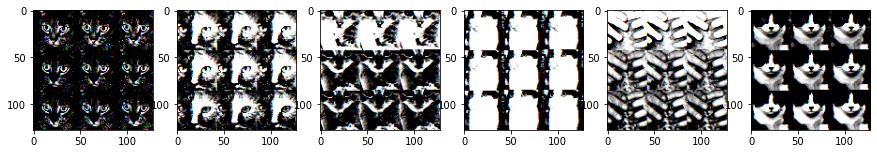

In [24]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

fig, axes = plt.subplots(figsize=(15,7), ncols = 6)
for i in range(6):
    ax = axes[i]
    images_new = images.view(64, 128,128, 3)
    img = ax.imshow(images_new[i])

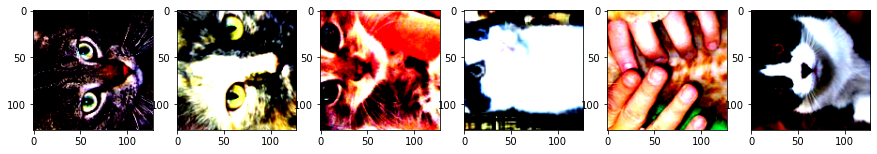

In [25]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

fig, axes = plt.subplots(figsize=(15,7), ncols = 6)
for i in range(6):
    ax = axes[i]
    img = ax.imshow(images[i].T)

In [32]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3, padding = 1, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 3, padding = 1, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 20, out_channels = 30, kernel_size = 3, padding = 1, stride = 1)
        self.conv4 = nn.Conv2d(in_channels = 30, out_channels = 40, kernel_size = 3, padding = 1, stride = 1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(40*8*8,3000)
        self.fc2 = nn.Linear(3000,1000)
        self.fc3 = nn.Linear(1000,100)
        self.fc4 = nn.Linear(100,2)
        self.drop = nn.Dropout(p = 0.2)
        self.conv2_drop = nn.Dropout2d(p = 0.01)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2_drop(self.conv2(x))))
        x = self.pool(F.relu(self.conv2_drop(self.conv3(x))))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 40*8*8)
        x = F.relu(self.drop(self.fc1(x)))
        x = F.relu(self.drop(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim = 0)
        
        return x
        
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(30, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2560, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=2, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (conv2_drop): Dropout2d(p=0.01, inplace=False)
)


In [29]:
criterion = nn.NLLLoss()

optimizer = optim.Adam(net.parameters(),
                      lr = 0.001)

EPOCHS = 10

for epoch in range(EPOCHS):
    for data in train_loader:
        X, y = data
        
        net.zero_grad()
        
        output = net(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
    print(loss)

tensor(1.6094, grad_fn=<NllLossBackward>)
tensor(1.6094, grad_fn=<NllLossBackward>)
tensor(1.6094, grad_fn=<NllLossBackward>)
tensor(1.6094, grad_fn=<NllLossBackward>)
tensor(1.6094, grad_fn=<NllLossBackward>)


In [30]:
correct = 0
total = 0

net.eval()
with torch.no_grad():
    for data in train_loader:
        X, y = data
        output = net(X)
        max_val, preds = torch.max(output, dim = 1)
            
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
                
            Accuracy = (correct/total)*100
            
print(correct, total)

3900 8005


In [31]:
print('Accuracy score = ', Accuracy)

Accuracy score =  48.71955028107433
